In [1]:
import numpy as np
import numba
import matplotlib.pyplot as plt
from scipy.spatial.distance import hamming
from time import time
from scipy.optimize import linear_sum_assignment
import arviz

#Import the helper functions and the Tabu sampling implementation
from WPSampler import *
from WPHelp import *

#Autocorrelation function as implemented by Power and Goldman
@numba.njit()
def autocorr(x, lags):
    mean=np.mean(x)
    var=np.var(x)
    xp=x-mean
    corr=[1. if l==0 else np.sum(xp[l:]*xp[:-l])/len(x)/var for l in lags]
    return np.array(corr)

In [2]:
#The main parameters
dim = int(1e2) #dimensionality of the state space
N = int(1e3) #sampling size
T_t = 1.5
T_z = 3.0
thin_rate_z = 0.015
thin_rate_t = 0.03
starting_state = np.arange(0, dim, step=1) #starting state

#Defining the Barker balancing function
g = lambda t: t/(1+t)

In [3]:
## The acceptance ratios/ess/mean reversion for 6 lambda values

#The list with the lambda values
lmbd_array = np.array([1, 2, 3, 4, 5])

#Effective sample size for the Hamming distance
ess_rw = np.zeros(5)
ess_pw = np.zeros(5)
ess_z = np.zeros(5)
ess_t = np.zeros(5)

#Acceptance rates
acc_rw_array = np.zeros(5)
acc_pw_array = np.zeros(5)

for i in np.arange(0, 5):
    #Placeholders to take the averages over
    inter_rw = np.zeros(5)
    inter_pw = np.zeros(5)
    inter_z = np.zeros(5)
    inter_t = np.zeros(5)
    
    inter_acc_rw = np.zeros(5)
    inter_acc_pw = np.zeros(5)
    for rep in np.arange(0,5):
        
        lmbd = lmbd_array[i]
        
        #Take the average of five random weight matrices
        weights = np.exp(np.random.normal(loc=0, scale=lmbd**2, size=(dim,dim)))
    
        
        baseline_state = linear_sum_assignment(-weights + np.min(weights))[1] #Highest probability baseline state

        #Running the random walk sampler
        trace_rw, energy_rw, hamming_rw, accepted_rw, runtime_rw = rw_sampler(dim, N, weights, starting_state, baseline_state)
        
        #Running the pointwise informed proposal sampler
        trace_pw, energy_pw, hamming_pw, accepted_pw, runtime_pw = pw_sampler(dim, N, weights, g, starting_state, baseline_state)
        
        #Running the Zanella sampler
        trace_z, energy_z, hamming_z, iter_z, runtime_z = zanella_sampler(dim, T_z, thin_rate_z, weights, g, starting_state, baseline_state)
        
        #Running the Tabu sampler
        trace_t, energy_t, hamming_t, alpha, iter_t, runtime_t = tabu_sampler(dim, T_t, thin_rate_t, weights, g, starting_state, baseline_state)
        
        #Calculating the acceptance ratios
        acc_rw = accepted_rw/N
        acc_pw = accepted_pw/N
        
        #In the placeholder arrays
        inter_rw[rep] = arviz.ess(hamming_rw)/runtime_rw
        inter_pw[rep] = arviz.ess(hamming_pw)/runtime_pw
        inter_z[rep] = arviz.ess(hamming_z)/runtime_z
        inter_t[rep] = arviz.ess(hamming_t)/runtime_t
        
        inter_acc_rw[rep] = acc_rw
        inter_acc_pw[rep] = acc_pw
        
    #Calulcating the effective sample sizes
    ess_rw[i] = np.mean(inter_rw)
    ess_pw[i] = np.mean(inter_pw)
    ess_z[i] = np.mean(inter_z)
    ess_t[i] = np.mean(inter_t)
    
    acc_rw_array[i] = np.mean(inter_acc_rw)
    acc_pw_array[i] = np.mean(inter_acc_pw)


Percent: [--------------------------------------->] 100%
Acceptance ratio:  0.389
Runtime:  0.06
Percent: [--------------------------------------->] 100%
Acceptance ratio:  0.713
Runtime:  4.39
Percent: [--------------------------------------->] 100%Runtime:  26.93
Percent: [--------------------------------------->] 99%Average excursion length:  2924.0
Runtime:  11.59
Percent: [--------------------------------------->] 100%
Acceptance ratio:  0.396
Runtime:  0.07
Percent: [--------------------------------------->] 100%
Acceptance ratio:  0.716
Runtime:  3.87
Percent: [--------------------------------------->] 100%Runtime:  27.95
Percent: [--------------------------------------->] 100%Average excursion length:  2808.0
Runtime:  10.26
Percent: [--------------------------------------->] 100%
Acceptance ratio:  0.39
Runtime:  0.07
Percent: [--------------------------------------->] 100%
Acceptance ratio:  0.717
Runtime:  3.97
Percent: [--------------------------------------->] 100%Runtime:

In [4]:
#Printing the results
print("---------------------------------------------------")
print("The acceptance ratios for the random walk sampler:")
print(acc_rw_array)
print("----------------------------------------------------")

print("---------------------------------------------------")
print("The acceptance ratios for the pointwise sampler:")
print(acc_pw_array)
print("----------------------------------------------------")

print("---------------------------------------------------")
print("The effective sample sizes for the random walk sampler:")
print(ess_rw)
print("----------------------------------------------------")

print("---------------------------------------------------")
print("The effective sample sizes for the pointwise sampler:")
print(ess_pw)
print("----------------------------------------------------")

print("---------------------------------------------------")
print("The effective sample sizes for the Zanella sampler:")
print(ess_z)
print("----------------------------------------------------")

print("---------------------------------------------------")
print("The effective sample sizes for the Tabu sampler:")
print(ess_t)
print("----------------------------------------------------")





---------------------------------------------------
The acceptance ratios for the random walk sampler:
[0.3876 0.1816 0.162  0.1422 0.1322]
----------------------------------------------------
---------------------------------------------------
The acceptance ratios for the pointwise sampler:
[0.7154 0.7778 0.8544 0.8708 0.8684]
----------------------------------------------------
---------------------------------------------------
The effective sample sizes for the random walk sampler:
[83.26702221 25.50773256 26.17975399 24.14365283 55.5518328 ]
----------------------------------------------------
---------------------------------------------------
The effective sample sizes for the pointwise sampler:
[1.59255857 0.34071737 0.44435326 0.352056   1.09723921]
----------------------------------------------------
---------------------------------------------------
The effective sample sizes for the Zanella sampler:
[  1.36323054   7.55182032   8.46282393  77.70855415 165.17251117]
------

In [5]:
## The parameters for the traceplots
lmbd = 5
dim = int(5e2) #dimensionality of the state space
weights = np.exp(np.random.normal(loc=0, scale=lmbd**2, size=(dim,dim)))
N = int(1e4) #sampling size
starting_state = np.arange(0, dim, step=1) #starting state
baseline_state = linear_sum_assignment(-weights + np.min(weights))[1] #highest probability baseline state

#The continuous-time sampler parameters
T_z = 150
thin_rate_z = 0.0150
T_t = 300
thin_rate_t = 0.03

In [6]:
#Running the random walk sampler
trace_rw, energy_rw, hamming_rw, accepted_rw, runtime_rw = rw_sampler(dim, N, weights, starting_state, baseline_state)

#Running the pointwise informed proposal sampler
trace_pw, energy_pw, hamming_pw, accepted_pw, runtime_pw = pw_sampler(dim, N, weights, g, starting_state, baseline_state)

#Running the Zanella sampler
trace_z, energy_z, hamming_z, iter_z, runtime_z = zanella_sampler(dim, T_z, thin_rate_z, weights, g, starting_state, baseline_state)

#Running the Tabu sampler
trace_t, energy_t, hamming_t, alpha, iter_t, runtime_t = tabu_sampler(dim, T_t, thin_rate_t, weights, g, starting_state, baseline_state)

Percent: [--------------------------------------->] 100%
Acceptance ratio:  0.0877
Runtime:  0.68
Percent: [--------------------------------------->] 100%
Acceptance ratio:  0.9078
Runtime:  206.22
Percent: [--------------------------------------->] 100%Runtime:  830.14
Percent: [--------------------------------------->] 100%Average excursion length:  30.0
Runtime:  1051.13


In [7]:
#The effective sample sizes of the Hamming distance
ESS_hamming_rw = arviz.ess(hamming_rw[int(0.2*N):])/runtime_rw
ESS_hamming_pw = arviz.ess(hamming_pw[int(0.2*N):])/runtime_pw
ESS_hamming_t = arviz.ess(hamming_z[int(0.2*N):])/runtime_t
ESS_hamming_z = arviz.ess(hamming_t[int(0.2*N):])/runtime_z

#The effective sample size of the log energy of the target density
ESS_energy_rw = arviz.ess(energy_rw[int(0.2*N):])/runtime_rw
ESS_energy_pw = arviz.ess(energy_pw[int(0.2*N):])/runtime_pw
ESS_energy_t = arviz.ess(energy_z[int(0.2*N):])/runtime_t
ESS_energy_z = arviz.ess(energy_t[int(0.2*N):])/runtime_z

#The acceptance ratios
acc_ratio_rw = accepted_rw/N
acc_ratio_pw = accepted_pw/N

#The mean reversion
mean_reversion = 33.0

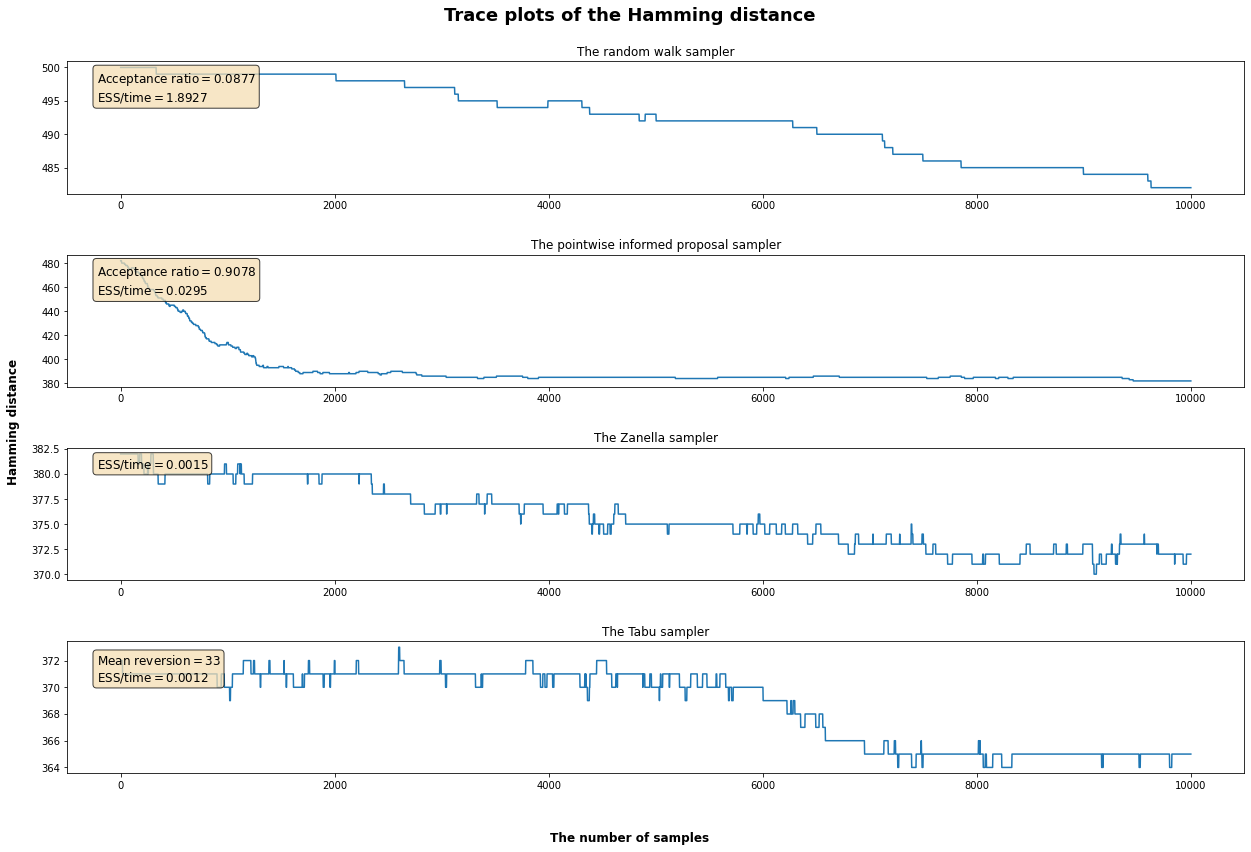

In [8]:
#Trace plots of the Hamming distance relative to the state with only ones
fig, ax = plt.subplots(4, 1, figsize=(18,12))
fig.suptitle("Trace plots of the Hamming distance", fontsize=18, fontweight="bold")
fig.supylabel("Hamming distance", fontweight="bold")
fig.supxlabel("The number of samples", fontweight="bold")
fig.tight_layout(h_pad=4, pad=2.5)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.75)

#The random walk subplot
ax[0].plot(hamming_rw)
ax[0].set_title("The random walk sampler")

#Adding a textbox
str_rw = '\n'.join((
    r'$\mathrm{Acceptance \ ratio}=%.4f$' % (acc_ratio_rw, ),
    r'$\mathrm{ESS/time}=%.4f$' % (ESS_hamming_rw, )))

ax[0].text(0.025, 0.7, str_rw,  fontsize=12, bbox=props, transform=ax[0].transAxes)

#The pointwise subplot
ax[1].plot(hamming_pw)
ax[1].set_title("The pointwise informed proposal sampler")

#Adding a textbox
str_pw = '\n'.join((
    r'$\mathrm{Acceptance \ ratio}=%.4f$' % (acc_ratio_pw, ),
    r'$\mathrm{ESS/time}=%.4f$' % (ESS_hamming_pw, )))

ax[1].text(0.025, 0.7, str_pw,  fontsize=12, bbox=props, transform=ax[1].transAxes)

#The Zanella sampler
ax[2].plot(hamming_z)
ax[2].set_title("The Zanella sampler")

#Adding a textbox
str_z = r'$\mathrm{ESS/time}=%.4f$' % (ESS_hamming_z, )


ax[2].text(0.025, 0.85, str_z,  fontsize=12, bbox=props, transform=ax[2].transAxes)

ax[3].plot(hamming_t)
ax[3].set_title("The Tabu sampler")

#Adding a textbox
str_t = '\n'.join((
    r'$\mathrm{Mean \ reversion}=%.0f$' % (mean_reversion, ),
    r'$\mathrm{ESS/time}=%.4f$' % (ESS_hamming_t, )))

ax[3].text(0.025, 0.7, str_t,  fontsize=12, bbox=props, transform=ax[3].transAxes)
plt.show()

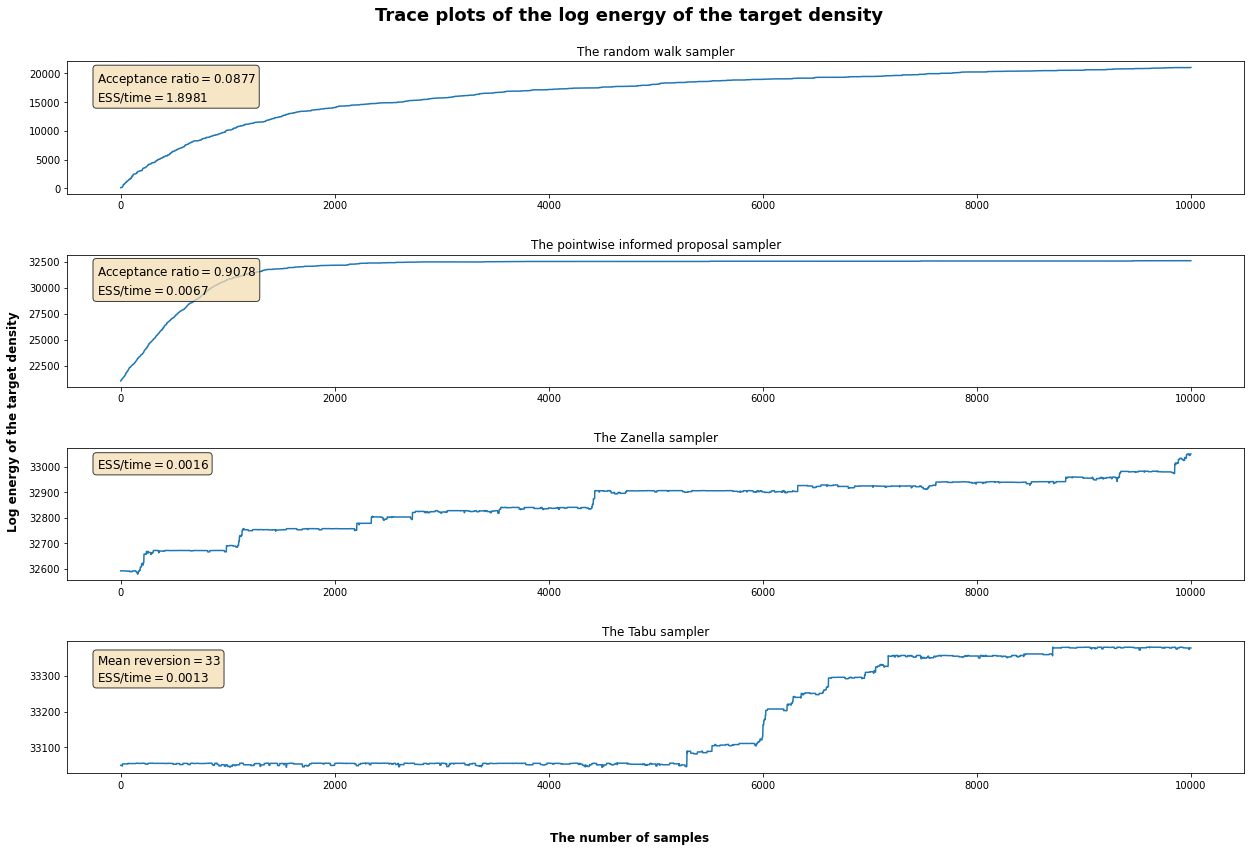

In [9]:
#Traceplots of the log energy of the target distribution
fig, ax = plt.subplots(4, 1, figsize=(18,12))
fig.suptitle("Trace plots of the log energy of the target density", fontsize=18, fontweight="bold")
fig.supylabel("Log energy of the target density", fontweight="bold")
fig.supxlabel("The number of samples", fontweight="bold")
fig.tight_layout(h_pad=4, pad=2.5)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.75)

#The random walk subplot
ax[0].plot(energy_rw)
ax[0].set_title("The random walk sampler")

#Adding a textbox
str_rw = '\n'.join((
    r'$\mathrm{Acceptance \ ratio}=%.4f$' % (acc_ratio_rw, ),
    r'$\mathrm{ESS/time}=%.4f$' % (ESS_energy_rw, )))

ax[0].text(0.025, 0.7, str_rw,  fontsize=12, bbox=props, transform=ax[0].transAxes)

#The pointwise subplot
ax[1].plot(energy_pw)
ax[1].set_title("The pointwise informed proposal sampler")

#Adding a textbox
str_pw = '\n'.join((
    r'$\mathrm{Acceptance \ ratio}=%.4f$' % (acc_ratio_pw, ),
    r'$\mathrm{ESS/time}=%.4f$' % (ESS_energy_pw, )))

ax[1].text(0.025, 0.7, str_pw,  fontsize=12, bbox=props, transform=ax[1].transAxes)

#The Zanella sampler
ax[2].plot(energy_z)
ax[2].set_title("The Zanella sampler")

#Adding a textbox
str_z = r'$\mathrm{ESS/time}=%.4f$' % (ESS_energy_z, )


ax[2].text(0.025, 0.85, str_z,  fontsize=12, bbox=props, transform=ax[2].transAxes)

ax[3].plot(energy_t)
ax[3].set_title("The Tabu sampler")

#Adding a textbox
str_t = '\n'.join((
    r'$\mathrm{Mean \ reversion}=%.0f$' % (mean_reversion, ),
    r'$\mathrm{ESS/time}=%.4f$' % (ESS_energy_t, )))

ax[3].text(0.025, 0.7, str_t,  fontsize=12, bbox=props, transform=ax[3].transAxes)
plt.show()

In [10]:
#Autocorrelation of the Hamming distance up to 3000 lags
acorr_hamming_rw = autocorr(hamming_rw[int(0.2*N):], np.arange(0, 3000))
acorr_hamming_pw = autocorr(hamming_pw[int(0.2*N):], np.arange(0, 3000))
acorr_hamming_z = autocorr(hamming_z[int(0.2*N):], np.arange(0, 3000))
acorr_hamming_t = autocorr(hamming_t[int(0.2*N):], np.arange(0, 3000))

#Autocorrelation of log energy of the target density up to 3000 lags
acorr_energy_rw = autocorr(energy_rw[int(0.2*N):], np.arange(0, 3000))
acorr_energy_pw = autocorr(energy_pw[int(0.2*N):], np.arange(0, 3000))
acorr_energy_z = autocorr(energy_z[int(0.2*N):], np.arange(0, 3000))
acorr_energy_t = autocorr(energy_t[int(0.2*N):], np.arange(0, 3000))

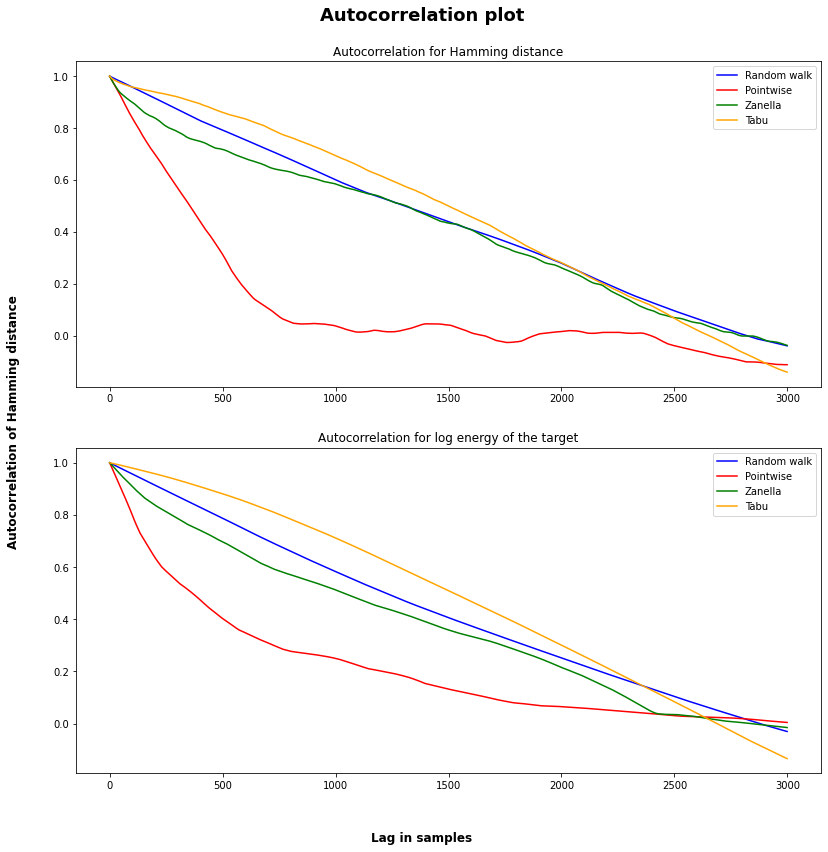

In [11]:
#The autocorrelation plot for the Hamming distance
fig, ax = plt.subplots(2, 1, figsize=(12,12))
fig.suptitle("Autocorrelation plot", fontsize=18, fontweight="bold")
fig.supylabel("Autocorrelation of Hamming distance", fontweight="bold")
fig.supxlabel("Lag in samples", fontweight="bold")
fig.tight_layout(h_pad=4, pad=2.5)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.75)

ax[0].plot(acorr_hamming_rw, label="Random walk", color="blue")
ax[0].plot(acorr_hamming_pw, label="Pointwise", color="red")
ax[0].plot(acorr_hamming_z, label="Zanella", color="green")
ax[0].plot(acorr_hamming_t, label="Tabu", color="orange")
ax[0].set_title("Autocorrelation for Hamming distance")
ax[0].legend()

ax[1].plot(acorr_energy_rw, label="Random walk", color="blue")
ax[1].plot(acorr_energy_pw, label="Pointwise", color="red")
ax[1].plot(acorr_energy_z, label="Zanella", color="green")
ax[1].plot(acorr_energy_t, label="Tabu", color="orange")
ax[1].set_title("Autocorrelation for log energy of the target")
ax[1].legend()


In [3]:
#Gelman-Rubin diagnostic; now for dim = 100
dim = int(1e2) #dimensionality of the state space
lmbd = 5
weights = np.exp(np.random.normal(loc=0, scale=lmbd**2, size=(dim,dim)))
starting_state = np.arange(0, dim, step=1) #starting state
baseline_state = linear_sum_assignment(-weights + np.min(weights))[1] #Highest probability baseline state

from GelmanRubinDiagnostic import *

#Running the overdispersed distribution
num_rw = 100
m = 10
N = 1000
N_samples, energy_rate, starting_states = start_sequences(dim, weights, N, num_rw, m)

#Convert all entries to integers
starting_states = starting_states.astype(int)

In [5]:
#Gelman-Rubin for n = 1000
n = int(1e3)
T_z = 15
thin_rate_z = 0.015
T_t = 30
thin_rate_t = 0.03
traces_rw = []
traces_pw = []
traces_z = []
traces_t = []
for i in np.arange(0,m):
    #Run the sampler in this case
    trace_rw, energy_rw, hamming_rw, num_acc_rw, runtime_rw = rw_sampler(dim, 2*n, weights, starting_states[i,:], baseline_state)
    trace_pw, energy_pw, hamming_pw, num_acc_pw, runtime_pw = pw_sampler(dim, 2*n, weights, g, starting_states[i,:], baseline_state)
    trace_z, energy_z, hamming_z, iter_z, runtime_z = zanella_sampler(dim, 2*T_z, thin_rate_z, weights, g, starting_states[i,:], baseline_state)
    trace_t, energy_t, hamming_t, alpha_t, iter_t, runtime_t = tabu_sampler(dim, 2*T_t, thin_rate_t, weights, g, starting_states[i,:], baseline_state)
    traces_rw.append(hamming_rw)
    traces_pw.append(energy_pw)
    traces_z.append(energy_z)
    traces_t.append(energy_t)
    
R_energy_rw = gelman_rubin(traces_rw, n, m)
R_energy_pw = gelman_rubin(traces_pw, n, m)
R_energy_z = gelman_rubin(traces_z, n, m)
R_energy_t = gelman_rubin(traces_t, n, m)

print("-------------------------------------------------------------------")
print("The scale reduction for the energy of the target_density: ",R_energy_rw)
print("-------------------------------------------------------------------")
print("-------------------------------------------------------------------")
print("The scale reduction for the energy of the target_density: ",R_energy_pw)
print("-------------------------------------------------------------------")
print("-------------------------------------------------------------------")
print("The scale reduction for the energy of the target_density: ",R_energy_z)
print("-------------------------------------------------------------------")
print("-------------------------------------------------------------------")
print("The scale reduction for the energy of the target_density: ",R_energy_t)
print("-------------------------------------------------------------------")


Percent: [--------------------------------------->] 100%
Acceptance ratio:  0.0095
Runtime:  0.14
Percent: [--------------------------------------->] 100%
Acceptance ratio:  0.988
Runtime:  7.94
Percent: [--------------------------------------> ] 96%Runtime:  6.21
Percent: [--------------------------------------->] 100%Average excursion length:  13.0
Runtime:  6.68
Percent: [--------------------------------------->] 100%
Acceptance ratio:  0.0095
Runtime:  0.17
Percent: [--------------------------------------->] 100%
Acceptance ratio:  1.0
Runtime:  8.23
Percent: [------------------------------------->  ] 94%Runtime:  6.05
Percent: [--------------------------------------->] 99%Average excursion length:  13.0
Runtime:  6.87
Percent: [--------------------------------------->] 100%
Acceptance ratio:  0.0115
Runtime:  0.15
Percent: [--------------------------------------->] 100%
Acceptance ratio:  0.9975
Runtime:  8.31
Percent: [--------------------------------------> ] 97%Runtime:  6.67
P

In [8]:
#Gelman-Rubin for n = 5000
n = int(5e3)
T_z = 75
thin_rate_z = 0.015
T_t = 150
thin_rate_t = 0.03
traces_rw = []
traces_pw = []
traces_z = []
traces_t = []
for i in np.arange(0,m):
    #Run the sampler in this case
    trace_rw, energy_rw, hamming_rw, num_acc_rw, runtime_rw = rw_sampler(dim, 2*n, weights, starting_states[i,:], baseline_state)
    trace_pw, energy_pw, hamming_pw, num_acc_pw, runtime_pw = pw_sampler(dim, 2*n, weights, g, starting_states[i,:], baseline_state)
    trace_z, energy_z, hamming_z, iter_z, runtime_z = zanella_sampler(dim, 2*T_z, thin_rate_z, weights, g, starting_states[i,:], baseline_state)
    trace_t, energy_t, hamming_t, alpha_t, iter_t, runtime_t = tabu_sampler(dim, 2*T_t, thin_rate_t, weights, g, starting_states[i,:], baseline_state)
    traces_rw.append(hamming_rw)
    traces_pw.append(energy_pw)
    traces_z.append(energy_z)
    traces_t.append(energy_t)
    
R_energy_rw = gelman_rubin(traces_rw, n, m)
R_energy_pw = gelman_rubin(traces_pw, n, m)
R_energy_z = gelman_rubin(traces_z, n, m)
R_energy_t = gelman_rubin(traces_t, n, m)

print("-------------------------------------------------------------------")
print("The scale reduction for the energy of the target_density: ",R_energy_rw)
print("-------------------------------------------------------------------")
print("-------------------------------------------------------------------")
print("The scale reduction for the energy of the target_density: ",R_energy_pw)
print("-------------------------------------------------------------------")
print("-------------------------------------------------------------------")
print("The scale reduction for the energy of the target_density: ",R_energy_z)
print("-------------------------------------------------------------------")
print("-------------------------------------------------------------------")
print("The scale reduction for the energy of the target_density: ",R_energy_t)
print("-------------------------------------------------------------------")

Percent: [--------------------------------------->] 100%
Acceptance ratio:  0.0098
Runtime:  0.8
Percent: [--------------------------------------->] 100%
Acceptance ratio:  0.9936
Runtime:  42.86
Percent: [--------------------------------------->] 100%Runtime:  31.37
Percent: [--------------------------------------->] 99%Average excursion length:  14.0
Runtime:  35.41
Percent: [--------------------------------------->] 100%
Acceptance ratio:  0.0099
Runtime:  0.72
Percent: [--------------------------------------->] 100%
Acceptance ratio:  0.9938
Runtime:  42.17
Percent: [--------------------------------------->] 99%Runtime:  33.16
Percent: [--------------------------------------->] 100%Average excursion length:  13.0
Runtime:  31.89
Percent: [--------------------------------------->] 100%
Acceptance ratio:  0.0112
Runtime:  1.03
Percent: [--------------------------------------->] 100%
Acceptance ratio:  0.987
Runtime:  41.8
Percent: [--------------------------------------->] 100%Runtim

In [7]:
#Gelman-Rubin for n = 10000
n = int(1e4)
T_z = 150
thin_rate_z = 0.015
T_t = 300
thin_rate_t = 0.03
traces_rw = []
traces_pw = []
traces_z = []
traces_t = []
for i in np.arange(0,m):
    #Run the sampler in this case
    trace_rw, energy_rw, hamming_rw, num_acc_rw, runtime_rw = rw_sampler(dim, 2*n, weights, starting_states[i,:], baseline_state)
    trace_pw, energy_pw, hamming_pw, num_acc_pw, runtime_pw = pw_sampler(dim, 2*n, weights, g, starting_states[i,:], baseline_state)
    trace_z, energy_z, hamming_z, iter_z, runtime_z = zanella_sampler(dim, 2*T_z, thin_rate_z, weights, g, starting_states[i,:], baseline_state)
    trace_t, energy_t, hamming_t, alpha_t, iter_t, runtime_t = tabu_sampler(dim, 2*T_t, thin_rate_t, weights, g, starting_states[i,:], baseline_state)
    traces_rw.append(hamming_rw)
    traces_pw.append(energy_pw)
    traces_z.append(energy_z)
    traces_t.append(energy_t)
    
R_energy_rw = gelman_rubin(traces_rw, n, m)
R_energy_pw = gelman_rubin(traces_pw, n, m)
R_energy_z = gelman_rubin(traces_z, n, m)
R_energy_t = gelman_rubin(traces_t, n, m)

print("-------------------------------------------------------------------")
print("The scale reduction for the energy of the target_density: ",R_energy_rw)
print("-------------------------------------------------------------------")
print("-------------------------------------------------------------------")
print("The scale reduction for the energy of the target_density: ",R_energy_pw)
print("-------------------------------------------------------------------")
print("-------------------------------------------------------------------")
print("The scale reduction for the energy of the target_density: ",R_energy_z)
print("-------------------------------------------------------------------")
print("-------------------------------------------------------------------")
print("The scale reduction for the energy of the target_density: ",R_energy_t)
print("-------------------------------------------------------------------")

Percent: [--------------------------------------->] 100%
Acceptance ratio:  0.0112
Runtime:  1.17
Percent: [--------------------------------------->] 100%
Acceptance ratio:  0.9924
Runtime:  79.19
Percent: [--------------------------------------->] 100%Runtime:  65.19
Percent: [--------------------------------------->] 100%Average excursion length:  13.0
Runtime:  66.86
Percent: [--------------------------------------->] 100%
Acceptance ratio:  0.01
Runtime:  1.62
Percent: [--------------------------------------->] 100%
Acceptance ratio:  0.9996
Runtime:  83.83
Percent: [--------------------------------------->] 100%Runtime:  61.07
Percent: [--------------------------------------->] 100%Average excursion length:  13.0
Runtime:  62.54
Percent: [--------------------------------------->] 100%
Acceptance ratio:  0.0096
Runtime:  1.61
Percent: [--------------------------------------->] 100%
Acceptance ratio:  0.9972
Runtime:  85.64
Percent: [--------------------------------------->] 100%Run